In [12]:
# %% Import
%load_ext autoreload
%autoreload 2

import math
import os
import magnum as mn
import numpy as np
from matplotlib import pyplot as plt
import habitat_sim

from utils.habitat.default_helper_functions import make_cfg
from utils.habitat.object_manipulation_helpers import set_object_state_relative_to_agent
from quaternion import quaternion, from_rotation_vector

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
# %% Configurations

# Settings
data_dir = '/home/baldeeb/Code/DINO-ViT-Experiments/data/downloaded'
hm3d_dir = f'{data_dir}/scene_datasets/hm3d/minival'
sim_settings = {
    "width":  640, #960, 
    "height": 480, #544,
    
    "scene":  f"{hm3d_dir}/00800-TEEsavR23oF/TEEsavR23oF.basis.glb",  # Scene path
    "scene_dataset_config":  f"{hm3d_dir}/hm3d_minival_basis.scene_dataset_config.json",  # MP3D scene dataset
    
    'color_sensor_hfov_1st_person': 60.2,
    'semantic_sensor_hfov_1st_person': 60.2,
    'depth_sensor_hfov_1st_person': 60.2, # 55.9,
    

    "default_agent": 0,
    "sensor_height": 1.5,  # Height of sensors in meters
    "sensor_pitch": -math.pi / 8.0,  # sensor pitch (x rotation in rads)
    "color_sensor_1st_person": True,  # RGB sensor
    "color_sensor_3rd_person": False,  # RGB sensor 3rd person
    "depth_sensor_1st_person": True,  # Depth sensor
    "semantic_sensor_1st_person": True,  # Semantic sensor
    "seed": 1,
    "enable_physics": True,  # enable dynamics simulation
}

# Generate Config
cfg = make_cfg(sim_settings)

# Assumes the object dir has a glb_file_list. Uses that file to return a list of all object dirs.
objects_folder = '/home/baldeeb/Code/DINO-ViT-Experiments/data/downloaded/objects/office_chair_models-20230215T191917Z-001'
with open(objects_folder+'/glb_file_list.txt', 'r') as f:
    object_dirs = [os.path.dirname(''.join([objects_folder, fdir.strip()])) for fdir in f.readlines()]

In [32]:
# %% Initialize Simulator

# clean-up the current simulator instance if it exists
sim = habitat_sim.Simulator(cfg)

# Managers of various Attributes templates
obj_attr_mgr = sim.get_object_template_manager()

# Load all objects of interst
for o_dir in object_dirs: obj_attr_mgr.load_configs(o_dir)

prim_attr_mgr = sim.get_asset_template_manager()
stage_attr_mgr = sim.get_stage_template_manager()
rigid_obj_mgr = sim.get_rigid_object_manager()


[12:20:15:141245]:[Metadata] AttributesManagerBase.h(380)::createFromJsonOrDefaultInternal : <Dataset>: Proposing JSON name : default.scene_dataset_config.json from original name : default| This file does not exist.
[12:20:15:141312]:[Metadata] AssetAttributesManager.cpp(123)::createObject : Asset attributes (capsule3DSolid:capsule3DSolid_hemiRings_4_cylRings_1_segments_12_halfLen_0.75_useTexCoords_false_useTangents_false) created and registered.
[12:20:15:141332]:[Metadata] AssetAttributesManager.cpp(123)::createObject : Asset attributes (capsule3DWireframe:capsule3DWireframe_hemiRings_8_cylRings_1_segments_16_halfLen_1) created and registered.
[12:20:15:141347]:[Metadata] AssetAttributesManager.cpp(123)::createObject : Asset attributes (coneSolid:coneSolid_segments_12_halfLen_1.25_rings_1_useTexCoords_false_useTangents_false_capEnd_true) created and registered.
[12:20:15:141358]:[Metadata] AssetAttributesManager.cpp(123)::createObject : Asset attributes (coneWireframe:coneWireframe_s

[12:20:15:141951]:[Metadata] SceneDatasetAttributesManager.cpp(310)::readDatasetJSONCell : "stages.default_attributes" set in Attributes Manager from JSON.
[12:20:15:142061]:[Metadata] AttributesManagerBase.h(352)::buildAttrSrcPathsFromJSONAndLoad : Glob path result for /home/baldeeb/Code/DINO-ViT-Experiments/data/downloaded/scene_datasets/hm3d/minival/0080[0-9]-???????????/*.basis.glb : /home/baldeeb/Code/DINO-ViT-Experiments/data/downloaded/scene_datasets/hm3d/minival/00800-TEEsavR23oF/TEEsavR23oF.basis.glb
[12:20:15:142127]:[Metadata] AttributesManagerBase.h(352)::buildAttrSrcPathsFromJSONAndLoad : Glob path result for /home/baldeeb/Code/DINO-ViT-Experiments/data/downloaded/scene_datasets/hm3d/minival/0080[0-9]-???????????/*.basis.glb : /home/baldeeb/Code/DINO-ViT-Experiments/data/downloaded/scene_datasets/hm3d/minival/00801-HaxA7YrQdEC/HaxA7YrQdEC.basis.glb
[12:20:15:142181]:[Metadata] AttributesManagerBase.h(352)::buildAttrSrcPathsFromJSONAndLoad : Glob path result for /home/balde

ata/default.physics_config.json) not found, so new default physics manager attributes created and registered.
[12:20:15:141651]:[Metadata] MetadataMediator.cpp(210)::setActiveSceneDatasetName : Attempting to create new dataset /home/baldeeb/Code/DINO-ViT-Experiments/data/downloaded/scene_datasets/hm3d/minival/hm3d_minival_basis.scene_dataset_config.json
[12:20:15:141660]:[Metadata] AttributesManagerBase.h(380)::createFromJsonOrDefaultInternal : <Dataset>: Proposing JSON name : /home/baldeeb/Code/DINO-ViT-Experiments/data/downloaded/scene_datasets/hm3d/minival/hm3d_minival_basis.scene_dataset_config.json from original name : /home/baldeeb/Code/DINO-ViT-Experiments/data/downloaded/scene_datasets/hm3d/minival/hm3d_minival_basis.scene_dataset_config.json| This file exists.
[12:20:15:141695]:[Metadata] AssetAttributesManager.cpp(123)::createObject : Asset attributes (capsule3DSolid:capsule3DSolid_hemiRings_4_cylRings_1_segments_12_halfLen_0.75_useTexCoords_false_useTangents_false) created a

In [33]:
# %% Set initial poses

# Define helper
def to_quaternion(x, y, z):
    Q = lambda a, v: mn.Quaternion.rotation(mn.Rad(a), mn.Vector3(v))
    return Q(x, (1.0, 0, 0)) * Q(y, (0, 1.0, 0)) * Q(z, (0, 0, 1.0))

# Move the robot
# NOTE: To get desired pose:
#   - use viewer to view map e.g. habitat-viewer ./habitat/data/scene_datasets/hm3d/minival/00800-TEEsavR23oF/TEEsavR23oF.basis.glb 
#   - move to pose and press `q` to print agent pose.
desired_rotation_quat = quaternion(0.765483, 0, 0.643456, 0.0)
desired_position = np.array([-5.9676,0.0,-0.899368])
# # Place robot in the air
# #   Useful for debugging
# desired_rotation_quat = from_rotation_vector([0, 0.0, 0.0])
# desired_position = np.array([0,10.0,2.0])

agent = sim.get_agent(0)
curr_state = agent.get_state()
curr_state.position = desired_position
curr_state.rotation = desired_rotation_quat
agent.set_state(curr_state)

# Initialize Object
rigid_obj_mgr.remove_all_objects()
object_file_handle = obj_attr_mgr.get_file_template_handles(object_dirs[1])
chair_obj = rigid_obj_mgr.add_object_by_template_handle(object_file_handle[0])
chair_obj.semantic_id = 1
chair_obj.rotation = mn.Quaternion.rotation(mn.Rad(np.pi/2), mn.Vector3([0, 1, 0]))
# chair_obj.translation = np.array([0, 10.0, 0.0])
set_object_state_relative_to_agent(sim, chair_obj, 
                offset=np.array([0, 1.0, -2.5]),
#                 absolute_orientation=False,
                orientation=to_quaternion(0, 0, 0))
#                 # orientation=to_quaternion(-100, 0, 0))

print('initial poses:')
print(f'position: {curr_state.position}  orientation: {curr_state.rotation}')
print(f'object_file_handle: {object_file_handle}')
print(f'position: {chair_obj.transformation}  orientation: {chair_obj.rotation}')

initial poses:[12:20:16:502859]:[Assets] ResourceManager.cpp(866)::loadRenderAsset : Loading general asset named: /home/baldeeb/Code/DINO-ViT-Experiments/data/downloaded/objects/office_chair_models-20230215T191917Z-001/office_chair_models/9368cd9028151e1e9d51a07a5989d077/models/model_normalized.glb

position: [-5.9676    0.       -0.899368]  orientation: quaternion(0.765483, 0, 0.643456, 0)
object_file_handle: ['/home/baldeeb/Code/DINO-ViT-Experiments/data/downloaded/objects/office_chair_models-20230215T191917Z-001/office_chair_models/9368cd9028151e1e9d51a07a5989d077/models/model_normalized.object_config.json']
position: Matrix(1, 0, 0, -8.43037,
       0, 1, 0, 1,
       0, 0, 1, -1.32919,
       0, 0, 0, 1)  orientation: Quaternion({0, 0, 0}, 1)
[12:20:16:502879]:[Assets] ResourceManager.cpp(1666)::configureImporterManagerGLExtensions : Importing Basis files as BC7.
[12:20:16:503175]:[Assets] ResourceManager.cpp(2232)::getMaterialShaderType : Shadertype being used for file : model_no

[12:20:16:506029]:[Physics] PhysicsManager.cpp(281)::addObject : Simplified template handle : model_normalized  | newObjectHandle : model_normalized_:0000


In [34]:
# Add Sphere for gravity experiments
BALL_DROP = False
if BALL_DROP:
    rigid_obj_mgr.remove_all_objects()
    obj_attr_mgr = sim.get_object_template_manager()
    prim_solid_obj_handles = obj_attr_mgr.get_synth_template_handles("sphere")
    obj_solid = rigid_obj_mgr.add_object_by_template_handle(prim_solid_obj_handles[0])
    obj_solid.mass = 10000000.0
    set_object_state_relative_to_agent(sim, obj_solid, 
                    offset=np.array([0, 2.0, -2.5]),
                    orientation=to_quaternion(0, 0, 0))

In [35]:
# %% Set object motion type
motion_type = 2  # 0:Static 1:Kineramic 2:Dynamic 

object_to_set = chair_obj
if BALL_DROP: object_to_set = obj_solid

if motion_type == 0:
    # Set object motion type to static
    object_to_set.motion_type = habitat_sim.physics.MotionType.STATIC

elif motion_type == 1:
    # Set object motion using velocity control
    object_to_set.motion_type = habitat_sim.physics.MotionType.KINEMATIC
    vel_control = object_to_set.velocity_control
    vel_control.controlling_lin_vel = True
    vel_control.controlling_ang_vel = True
    vel_control.angular_velocity = mn.Vector3((0.0, 0.5, 0.0))

elif motion_type == 2:
    object_to_set.motion_type = habitat_sim.physics.MotionType.DYNAMIC 

Saving data to data/generated/test


100%|██████████| 3/3 [00:06<00:00,  2.01s/it]


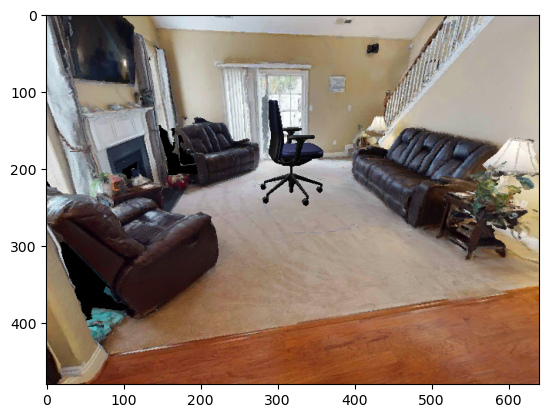

dict_keys(['color', 'depth', 'mask', 'coord', 'objects', 'word_T_agent'])
dict_keys(['camera_T_image', 'camera_T_object', 'world_T_rgb', 'semantic_id', 'bbox'])
This data loader has 3 steps left.


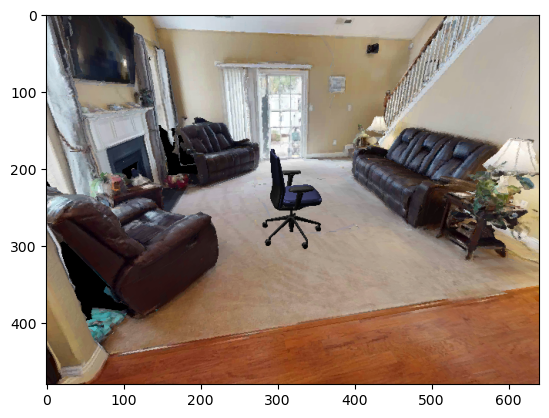

dict_keys(['color', 'depth', 'mask', 'coord', 'objects', 'word_T_agent'])
dict_keys(['camera_T_image', 'camera_T_object', 'world_T_rgb', 'semantic_id', 'bbox'])
This data loader has 3 steps left.


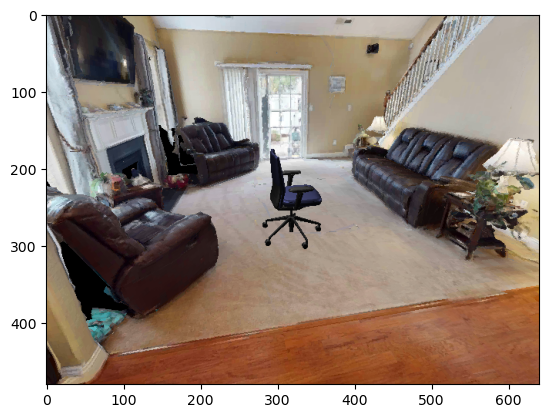

dict_keys(['color', 'depth', 'mask', 'coord', 'objects', 'word_T_agent'])
dict_keys(['camera_T_image', 'camera_T_object', 'world_T_rgb', 'semantic_id', 'bbox'])
This data loader has 3 steps left.


In [36]:
# %%Generates data and saves it to data/generated/test

# Instantiate dataloader
from utils.habitat.datatools import SimulationDataStreamer
from utils.habitat.datatools import HabitatDataloader
import matplotlib.pyplot as plt
import numpy as np

sim_dataloader_config = {
    # step config
    'step_type': 'physics',
    'duration':2.10, 
    'frequency':1.50,
    
    'object_file_handles': rigid_obj_mgr.get_object_handles(),

    'rgb_sensor':'color_sensor_1st_person',
    'depth_sensor':'depth_sensor_1st_person',
    'semantic_sensor':'semantic_sensor_1st_person'
}
folder = 'data/generated/test'

dataloader = SimulationDataStreamer(sim, sim_dataloader_config)
dataloader.save(folder, override=True)

hdl = HabitatDataloader(f'{folder}/metadata.json')
for i, (rgb, depth, semantics, nocs, meta) in enumerate(hdl):    
    plt.figure(); plt.imshow(rgb)
    # plt.figure(); plt.imshow(depth)
    # plt.figure(); plt.imshow(semantics)
    plt.show()
    print(meta.keys())
    for ok, ov in meta['objects'].items(): 
        print(ov.keys()); break
    
    print(f'This data loader has {len(hdl)} steps left.')

In [28]:
# If a ball was dropped compare the height of the ball with the starting height
if BALL_DROP:
    print(f'Ball height: {obj_solid.translation[1]}')
    print(f'Floor height: {sim.pathfinder.get_bounds()[0][1]}')

### Visualize nocs projection

The intention here is to verify that the resultant loaded nocs image can be reprojected to match the depth reprojection viewed by the robot.
This is merely a test.

unique semantic classes [0 1]


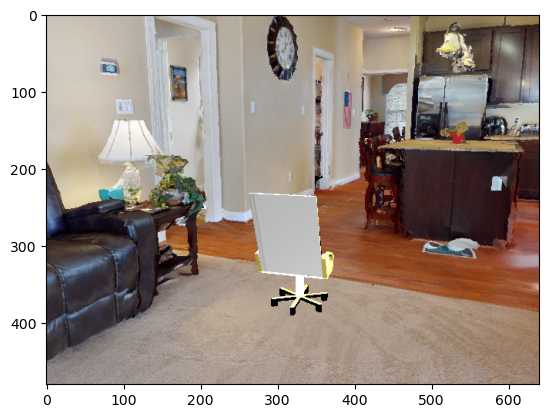

################################################## 
 dict_keys(['model_normalized_:0000']) 
 ##################################################
[0 1]
1.135140728572128
nocs min: [-0.20699625 -0.36725141 -0.2693177 ]   max  [0.19809319 0.36725141 0.2693177 ]
nocs scale: 0.9968550293648699
re-projection min: [-0.20403283 -0.36519444 -0.26814424]   max  [0.19974156 0.36958329 0.27300314]
nocs scale: 0.9978840375212283
bbox min [-0.24197999 -0.4077315  -0.3119885 ]    max:  [0.24197999 0.4077315  0.3119885 ]


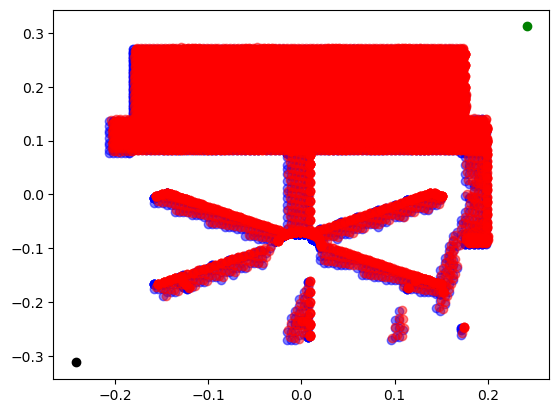

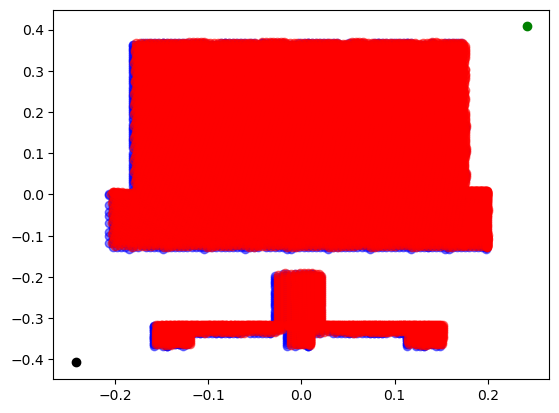

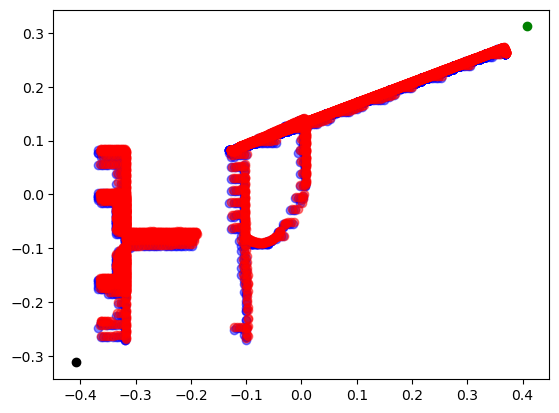

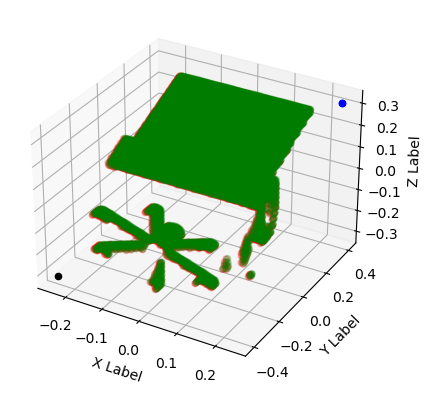

In [3]:
# Instantiate dataloader
from utils.habitat.datatools import HabitatDataloader
import matplotlib.pyplot as plt
import numpy as np

# folder = '/home/baldeeb/Code/DINO-ViT-Experiments/data/generated/new_medium_manyScene_oneChair/00837-vBMLrTe4uLA'
# folder = 'data/generated/test'
folder = '/home/baldeeb/Code/DINO-ViT-Experiments/data/generated/100scenes_allOjbects_300viewsEach/train/00800-TEEsavR23oF'


hdl = HabitatDataloader(f'{folder}/metadata.json')
for i, (rgb, depth, semantics, nocs, meta) in enumerate(hdl):    
    print(f'unique semantic classes {np.unique(semantics)}')

    plt.figure(); plt.imshow(rgb); plt.show()
    print('#'*50,'\n', meta['objects'].keys(),'\n', '#'*50)

    mask = np.zeros_like(semantics)
    print(np.unique(semantics))
    mask[semantics == 1] = 1
    intrinsic = hdl.intrinsic()
    
    # project 2d mask to 3d
    ij = np.where(mask == 1)
    xy1 = np.vstack((ij[1], ij[0], np.ones_like(ij[0])))
    xyz = np.linalg.inv(intrinsic) @ xy1 * depth[ij]
    xyz1 = np.vstack((xyz, np.ones_like(ij[0])))
    
    # transform object to origin
    obj_meta = meta['objects']['model_normalized_:0000']
    camera_T_object = np.array(obj_meta['camera_T_object'])
    camera_T_image = np.diag([1.0,  -1.0,  -1.0, 1.0])
    image_T_object = np.linalg.inv(camera_T_object) @ camera_T_image
    centered_xyz = (image_T_object @ xyz1)[:3]
    xs, ys, zs = centered_xyz  

    bbox_min, bbox_max = np.array(obj_meta['bbox']['min']), np.array(obj_meta['bbox']['max'])
    bbox_diag = bbox_max - bbox_min
    scale = np.linalg.norm(bbox_diag)
    select_nocs = nocs[ij[0], ij[1]].astype(np.float64) / 255.0
    select_nocs = select_nocs - 0.5
    select_nocs *= scale
    # select_nocs = select_nocs - (bbox_diag/2.0)
    # select_nocs[:, 0] = -select_nocs[:, 0] 
    nxs, nys, nzs = select_nocs[:, 0], select_nocs[:, 1], select_nocs[:, 2]
    
    plt.figure(); plt.scatter(nxs, nzs, color='b', alpha=0.5); plt.scatter(xs, zs, color='r', alpha=0.5)
    plt.scatter([bbox_min[0]], [bbox_min[2]], color='black'); plt.scatter([bbox_max[0]], [bbox_max[2]], color='green')
    plt.figure(); plt.scatter(nxs, nys, color='b', alpha=0.5); plt.scatter(xs, ys, color='r', alpha=0.5)
    plt.scatter([bbox_min[0]], [bbox_min[1]], color='black'); plt.scatter([bbox_max[0]], [bbox_max[1]], color='green')
    plt.figure(); plt.scatter(nys, nzs, color='b', alpha=0.5); plt.scatter(ys, zs, color='r', alpha=0.5)
    plt.scatter([bbox_min[1]], [bbox_min[2]], color='black'); plt.scatter([bbox_max[1]], [bbox_max[2]], color='green')
    
    print(scale)


    nmin = select_nocs.min(axis=0)
    nmax = select_nocs.max(axis=0)
    nscale= np.linalg.norm(nmax - nmin)
    dmin = centered_xyz.min(axis=1)
    dmax = centered_xyz.max(axis=1)
    dscale= np.linalg.norm(dmax - dmin)
    print(f'nocs min: {nmin}   max  {nmax}')
    print(f'nocs scale: {nscale}')
    print(f're-projection min: {dmin}   max  {dmax}')
    print(f'nocs scale: {dscale}')
    print(f'bbox min {bbox_min}    max:  {bbox_max}')

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(xs, ys, zs, marker='o', color='g', alpha=0.25)
    ax.scatter(nxs, nys, nzs, marker='o', color='r', alpha=0.25)


    ax.scatter(bbox_min[0], bbox_min[1], bbox_min[2], color='black')
    ax.scatter(bbox_max[0], bbox_max[1], bbox_max[2], color='blue')
    ax.scatter(bbox_max[0], bbox_max[1], bbox_max[2], color='blue')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    # print(meta.keys())
    # for ok, ov in meta['objects'].items(): 
    #     print(ov.keys()); break
    
    # print(f'This data loader has {len(hdl)} steps left.')
    break

In [9]:
# Scratch tests

gt_rt = np.array([[-8.99488807e-01, -8.28758712e-05,  6.93885386e-01, -1.42050639e-01],
  [-7.01210275e-02 ,-1.13020039e+00 ,-9.10333917e-02 ,-2.16774317e-03],
  [ 6.90333247e-01 ,-1.14908792e-01 , 8.94870400e-01 , 2.00573587e+00],
  [ 0.00000000e+00 , 0.00000000e+00 , 0.00000000e+00 , 1.00000000e+00]])
pred_rt = np.array(
  [[ 0.14059952 ,-0.12386367, -1.09444726, -0.26462716],
   [-0.26833403 ,-1.07393706,  0.08707058, -0.00439207],
   [-1.06824803 , 0.2534605 , -0.16591911,  2.14868999],
   [ 0.         , 0.        ,  0.        ,  1.        ],])
np.linalg.norm((pred_rt @ np.linalg.inv(gt_rt)) - np.eye(4))

4.5995589945915265

# overlay results

In [6]:
%matplotlib qt 
import cv2
from habitat_tools.utils.datatools import HabitatDataloader
import matplotlib.pyplot as plt
import numpy as np

folder = 'data/generated/test/00802-wcojb4TFT35'
# folder = '/home/baldeeb/Code/nocs_catkin_ws/src/nocs_ros_pkg/src/nocs/data/habitat/val/0000'
hdl = HabitatDataloader(f'{folder}/metadata.json')

for i, (rgb, depth, semantics, nocs, meta) in enumerate(hdl):
    plt.figure(); plt.imshow(rgb)
    plt.figure(); plt.imshow(depth)
    plt.figure(); plt.imshow(semantics)
    print(meta.keys())
    for ok, ov in meta['objects'].items(): 
        print(ov.keys()); break


    semantics = semantics.astype(np.uint8)
    semantics = np.stack([semantics, semantics,semantics], axis=-1)*255
    print(nocs.dtype, nocs.shape, semantics.dtype, semantics.shape)
    b = cv2.addWeighted(semantics, 0.5, nocs, 0.5, 0.0)
    plt.figure(); plt.title('nocs & mask overlayed'); plt.imshow(b)
    nocs[nocs == 0] = 255
    plt.figure(); plt.title('nocs'); plt.imshow(nocs)
    plt.figure(); plt.imshow(semantics)
    plt.show()

    # print(f'This data loader has {len(hdl)} steps left.')

    # print('----------------------------------------')
    # print(f'nocs min: {np.min(nocs)} max: {np.max(nocs)}')
    # print('\n\n')

    if i > 2: break


dict_keys(['color', 'depth', 'mask', 'coord', 'objects', 'word_T_agent'])
dict_keys(['camera_T_image', 'camera_T_object', 'world_T_rgb', 'semantic_id', 'bbox'])
uint8 (480, 640, 3) uint8 (480, 640, 3)
dict_keys(['color', 'depth', 'mask', 'coord', 'objects', 'word_T_agent'])
dict_keys(['camera_T_image', 'camera_T_object', 'world_T_rgb', 'semantic_id', 'bbox'])
uint8 (480, 640, 3) uint8 (480, 640, 3)
dict_keys(['color', 'depth', 'mask', 'coord', 'objects', 'word_T_agent'])
dict_keys(['camera_T_image', 'camera_T_object', 'world_T_rgb', 'semantic_id', 'bbox'])
uint8 (480, 640, 3) uint8 (480, 640, 3)
dict_keys(['color', 'depth', 'mask', 'coord', 'objects', 'word_T_agent'])
dict_keys(['camera_T_image', 'camera_T_object', 'world_T_rgb', 'semantic_id', 'bbox'])
uint8 (480, 640, 3) uint8 (480, 640, 3)


/tmp/ipykernel_1526318/1145076787.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(); plt.imshow(semantics)
/tmp/ipykernel_1526318/1145076787.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(); plt.title('nocs & mask overlayed'); plt.imshow(b)
/tmp/ipykernel_1526318/1145076787.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rc

## Can we find space to randomly place objects in a scene?

In [ ]:
# Visualization functions

def display_map(topdown_map, key_points=None):
    '''display a topdown map with matplotlib'''
    plt.figure(figsize=(12, 8))
    ax = plt.subplot(1, 1, 1)
    ax.axis("off")
    plt.imshow(topdown_map)
    # plot points on map
    if key_points is not None:
        for point in key_points:
            plt.plot(point[0], point[1], marker="o", markersize=10, alpha=0.8)
    plt.show(block=False)


def test_topdown_map(meters_per_pixel = 0.1, height=-0.2):
    if not sim.pathfinder.is_loaded:
        print("Pathfinder not initialized, aborting.")
    else:
        # @markdown You can get the topdown map directly from the Habitat-sim API with *PathFinder.get_topdown_view*.
        # This map is a 2D boolean array
        sim_topdown_map = sim.pathfinder.get_topdown_view(meters_per_pixel, height)

        if display:
            # @markdown Alternatively, you can process the map using the Habitat-Lab [maps module](https://github.com/facebookresearch/habitat-lab/blob/main/habitat/utils/visualizations/maps.py)
            hablab_topdown_map = maps.get_topdown_map(
                sim.pathfinder, height, meters_per_pixel=meters_per_pixel
            )
            recolor_map = np.array(
                [[255, 255, 255], [128, 128, 128], [0, 0, 0]], dtype=np.uint8
            )
            hablab_topdown_map = recolor_map[hablab_topdown_map]
            print("Displaying the raw map from get_topdown_view:")
            display_map(sim_topdown_map)
            print("Displaying the map from the Habitat-Lab maps module:")
            display_map(hablab_topdown_map)

def vis_xyz_topdown(rob, obj, m_per_px, lower_bound):
    rob = ((rob - lower_bound) / m_per_px).astype(int)[[0,2]]
    obj = ((obj - lower_bound) / m_per_px).astype(int)[[0,2]]
    sim_topdown_map = sim.pathfinder.get_topdown_view(m_per_px, height)
    dist_map = distance_map_from_binary_matrix(np.invert(sim_topdown_map))
    dist_map[rob[1], rob[0]] = 20
    dist_map[obj[1], obj[0]] = -10
    display_map(dist_map)  # Display areas far from walls
    # plt.plot(dist_map.reshape(-1), 'o')

In [ ]:
from habitat.utils.visualizations import maps
from distancemap import distance_map_from_binary_matrix 

height = sim.pathfinder.get_bounds()[0][1]  # get bounding box minumum
meters_per_pixel = 0.1  
sim_topdown_map = sim.pathfinder.get_topdown_view(meters_per_pixel, height)
dist_map = distance_map_from_binary_matrix(np.invert(sim_topdown_map))

min_clearence_m = 0.5
min_clearence_px = np.ceil(min_clearence_m / meters_per_pixel)
object_px_candidates = np.stack(np.where(dist_map > min_clearence_px), axis=0)  # [2, N]
robot_px_candidates = np.stack(np.where(dist_map > 0.2), axis=0)
# print(f'object_px_candidates shape: {object_px_candidates.shape}   -   2xN')
# print(f'robot_px_candidates shape: {robot_px_candidates.shape}   -   2xN')

if False:  # Visualize the distance map  
    meters_per_pixel = 0.1  
    sim_topdown_map = sim.pathfinder.get_topdown_view(meters_per_pixel, height)
    dist_map = distance_map_from_binary_matrix(np.invert(sim_topdown_map))
    dist_map[object_px_candidates[0][:], object_px_candidates[1][:]] = 20
    # dist_map[ij_select[0][0], ij_select[1][0]] = 15
    display_map(dist_map)  # Display areas far from walls

In [ ]:
from utils.habitat.env_constrained_position_sampling  import ObjectAndRobotPoseGenerator
config = {
    '_m_per_px': 0.1, 
    '_min_obj_clearence_m': 0.5,    # distance of object form obstacles
    '_min_rob_clearence_m': 0.2,    # distance of robot form obstacles
                                    # NOTE: Only first floor for now
    '_min_obj2rob_dist_m': 2  ,
    '_max_obj2rob_dist_m': 6  ,
    '_min_path_dist_from_obstacles': 0.2,
}
rob_xyz, rob_theta, obj_xyz = ObjectAndRobotPoseGenerator(sim, config)()
print(f'returned {rob_xyz.shape[1]} possible pairs...')

returned 1048 possible pairs...


In [ ]:
i=0

selected: position->[-1.54700146 -0.23662207 -2.87288036], theta->quaternion(0.707106781186548, 0, 0.707106781186547, 0)


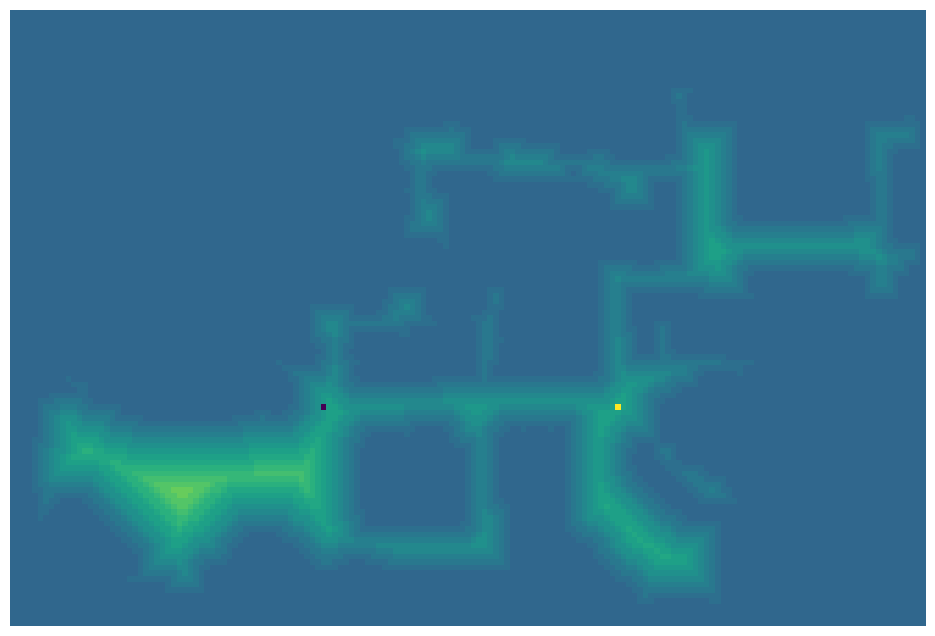

In [ ]:
# select sample for experiment
from quaternion import from_rotation_vector

# i = np.random.choice(np.arange(rob_xyz.shape[1]))

select_position = rob_xyz[:, i]
select_theta = rob_theta[i]

select_obj_position = obj_xyz[:, i]

# select_rotation = from_rotation_vector([0.0, select_theta, 0.0])
print(f'selected: position->{select_position}, theta->{select_theta}')

lb = np.array(sim.pathfinder.get_bounds()[0])
vis_xyz_topdown(select_position, select_obj_position, 0.1, lb)
i+=1

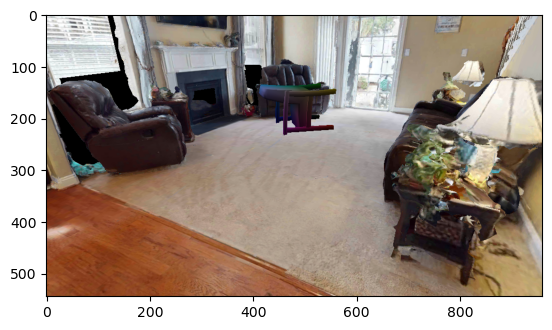

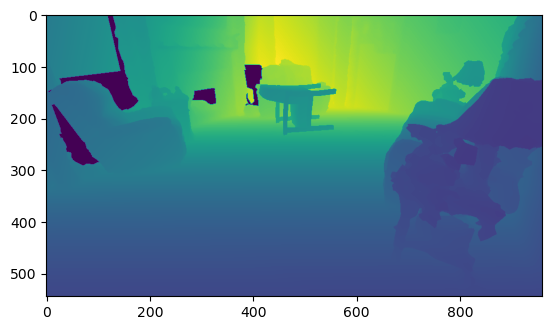

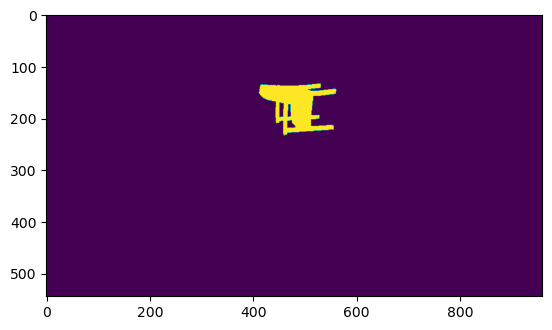

dict_keys(['rgb', 'depth', 'semantics', 'objects', 'agent_T'])
dict_keys(['transformation', 'semantic_id'])


In [ ]:
state = sim.get_agent(0).get_state()
state.position, state.rotation = select_position, select_rotation
agent.set_state(state)
temp = select_obj_position.copy(); temp[1] += 0.75
chair_obj.translation = temp
# chair_obj.translation = select_obj_position

# Instantiate dataloader
from habitat_tools.utils.datatools import SimulationDataStreamer
sim_dataloader_config = {
    'duration':14.5, 
    'frequency':1.0,
    'rgb_sensor':'color_sensor_1st_person',
    'depth_sensor':'depth_sensor_1st_person',
    'semantic_sensor':'semantic_sensor_1st_person'
}
dataloader = SimulationDataStreamer(sim, sim_dataloader_config)

folder = 'data/temp_test'
dataloader.save(folder, override=True)


from habitat_tools.utils.datatools import HabitatDataloader

hdl = HabitatDataloader('data/temp_test/metadata.json')
for i, (rgb, depth, semantics, meta) in enumerate(hdl):
    if rgb is None: break  # TODO: fix this
    plt.figure(); plt.imshow(rgb)
    plt.figure(); plt.imshow(depth)
    plt.figure(); plt.imshow(semantics)
    plt.show()
    print(meta.keys())
    for ok, ov in meta['objects'].items(): 
        print(ov.keys()); break
    break


# Testing data generation by teleportation

The issue being tested:
- is the code able to consistently position the object on the ground without having to drop it and rely on dynamics

NOTICE: all objects are assumed to be of the same class: 7


[10:52:06:417228]:[Metadata] SceneDatasetAttributesManager.cpp(310)::readDatasetJSONCell : "stages.default_attributes" set in Attributes Manager from JSON.
[10:52:06:417954]:[Metadata] AttributesManagerBase.h(352)::buildAttrSrcPathsFromJSONAndLoad : Glob path result for /home/baldeeb/Code/DINO-ViT-Experiments/data/downloaded/scene_datasets/hm3d/val/008[0-9][0-9]-???????????/*.basis.glb : /home/baldeeb/Code/DINO-ViT-Experiments/data/downloaded/scene_datasets/hm3d/val/00800-TEEsavR23oF/TEEsavR23oF.basis.glb
[10:52:06:418011]:[Metadata] AttributesManagerBase.h(352)::buildAttrSrcPathsFromJSONAndLoad : Glob path result for /home/baldeeb/Code/DINO-ViT-Experiments/data/downloaded/scene_datasets/hm3d/val/008[0-9][0-9]-???????????/*.basis.glb : /home/baldeeb/Code/DINO-ViT-Experiments/data/downloaded/scene_datasets/hm3d/val/00801-HaxA7YrQdEC/HaxA7YrQdEC.basis.glb
[10:52:06:418057]:[Metadata] AttributesManagerBase.h(352)::buildAttrSrcPathsFromJSONAndLoad : Glob path result for /home/baldeeb/Code/

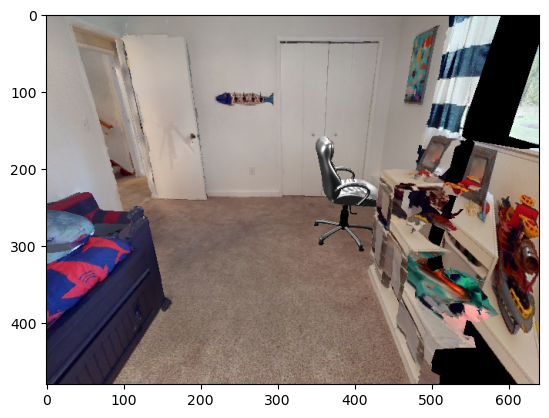

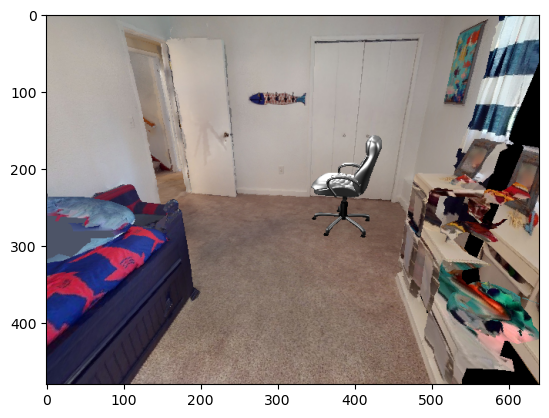


Data Generated Successfully!


In [ ]:
# %% TODO list
# - [x] Add the ability to generate a dataset per scene
# - [x] Support more than one and different combinations of objects
# - [x] Allow the teleport-datagen algo to use multiple floors

# %% Import all that is needed
import math
import os
import magnum as mn
import numpy as np
from quaternion import quaternion
from matplotlib import pyplot as plt
import pathlib

import habitat_sim
from utils.habitat.default_helper_functions import make_cfg
from utils.habitat.datatools import HabitatDataloader, SimulationDataStreamer


# %%  Habitat Setup
GEN_METHOD = 'Teleport'
DATA_DIR = '/home/baldeeb/Code/DINO-ViT-Experiments/data/downloaded'
OVERRIDE_EXISTING_DATA = False

# Set scenes to use
SCENE_DIR = f'{DATA_DIR}/scene_datasets/hm3d/val'
scene_config = f'{SCENE_DIR}/hm3d_val_basis.scene_dataset_config.json'  # We needed a non-anotated scene 
                                                                        # to control semantic annotations
num_scenes_to_use = 1
scene_glb_list = [os.path.join(SCENE_DIR, scene, f'{scene.split("-")[-1]}.glb') for scene  in os.listdir(SCENE_DIR)]
scene_glb_list = scene_glb_list[:num_scenes_to_use]

# Collect list of object folders in directory
####################################################################################
# TODO: FIX THIS. Code currently assumes all objects are of the same class.
####################################################################################
OBJECT_CLASS = 7  
OBJECTS_DIR = f'{DATA_DIR}/objects/office_chair_models-20230215T191917Z-001'
print(f'NOTICE: all objects are assumed to be of the same class: {OBJECT_CLASS}')
all_obj_folders = [str(obj_f) for obj_f in pathlib.Path(OBJECTS_DIR).rglob('*.obj')]
scene_obj_folders = [[all_obj_folders[i]] for i in 
                     np.random.randint(0, len(all_obj_folders), len(scene_glb_list))]

for (object_folders, scene_glb) in zip(scene_obj_folders, scene_glb_list):
    
    sim_settings = {
        "gpu_device_id": 0,
        
        # TODO: make 640 x 512 like spot
        "width": 640,
        "height": 480,
        
        "scene":  scene_glb,
        "scene_dataset_config": scene_config,
        
        "default_agent": 0,
        "sensor_height": 1.5,  # Height of sensors in meters
        "sensor_pitch": -math.pi / 8.0,  # sensor pitch (x rotation in rads)
        "color_sensor_1st_person": True,  # RGB sensor
        "color_sensor_3rd_person": False,  # RGB sensor 3rd person
        "depth_sensor_1st_person": True,  # Depth sensor
        "semantic_sensor_1st_person": True,  # Semantic sensor
        "seed": 1,
        "enable_physics": True,  # enable dynamics simulation
    }

    # Generate Config
    cfg = make_cfg(sim_settings)


    try:
        sim = habitat_sim.Simulator(cfg)
    except Exception as e:
        print('#'*50, e, '#'*50); continue

    # Get managers
    obj_attr_mgr = sim.get_object_template_manager()
    rigid_obj_mgr = sim.get_rigid_object_manager()

    if len(object_folders) > 1:
        print(f'NOTICE: more than one object folder was provided, only the first will be used')

    # Load all objects of interst
    for obj_idx, obj_f in enumerate(object_folders): 
        obj_attr_mgr.load_configs(obj_f)
        f_handle = obj_attr_mgr.get_file_template_handles(obj_f)[0]
        obj = rigid_obj_mgr.add_object_by_template_handle(f_handle)
        obj.semantic_id = obj_idx + 1
        obj.user_attributes.set('class', OBJECT_CLASS)
    common_dataloader_configs = {
            'object_file_handles': rigid_obj_mgr.get_object_handles(),

            # When set, the streaming class saves relative object locations 
            #   in a meta file instead of the complete location
            'object_models_path': os.path.join(DATA_DIR,'objects'),  

            'rgb_sensor':'color_sensor_1st_person',
            'depth_sensor':'depth_sensor_1st_person',
            'semantic_sensor':'semantic_sensor_1st_person'
        }

    # Instantiate dataloader
    sim_dataloader_config = {
        # step config
        'step_type': 'teleport',
        '_m_per_px': 0.1, 

        # distance of object form obstacles
        '_min_obj_clearence_m': 0.7,    
        
        # distance of robot form obstacles
        '_min_rob_clearence_m': 0.2,   # NOTE: Only first floor for now
        '_min_obj2rob_dist_m': 2  ,
        '_max_obj2rob_dist_m': 6  ,
        '_min_path_dist_from_obstacles': 0.2,

        # if set only samples that many pose pairs
        'sample_count': 3,              
        
        # simulate gravity for this many seconds
        # 'simulate_gravity_for_s': 1,  
    }
    sim_dataloader_config.update(common_dataloader_configs)

    # %% Run the data generator
    try:
        dataloader = SimulationDataStreamer(sim, sim_dataloader_config)
        
        for result in dataloader:
            plt.figure()
            plt.imshow(result['rgb'])
            plt.show()
            # print(result.keys())
            # break
        
        print("\nData Generated Successfully!")
    except StopIteration as e:  # TODO: Make custom exception
        print("Failed to generate and save data...")
        print(e)
    except RuntimeError as e:  # TODO: Make custom exception
        print("Failed to generate and save data...")
        print(e)
    sim.close()